In [1]:
#import libraries
import requests
import zipfile
import io
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
import seaborn as sns
import fiona

In [2]:
path = "c:/Users/lilyd/Downloads/research_summer_2024/"
full_df=pd.read_csv("C:/Users\lilyd\Downloads/research_summer_2024\quality_data.csv")
#Import CSI Data downloaded from website
csi_data = pd.read_csv('C:/Users\lilyd\Downloads\Community Science Institute - Download - 03-10-2025 08_30_08.csv')

#Import CSI Sampling Locations
csi_locs = pd.read_csv(path+'CSI-all_monitoring_regions_with_lat_long(AutoRecovered).csv')

#Format Data to Match that of the WQP
csi_data = csi_data[['Monitoring Location','Date','Analyte','Value','Unit',]]
csi_data = csi_data.rename(columns={'Monitoring Location':"MonitoringLocationIdentifier", 'Date':"ActivityStartDate", 'Analyte':"CharacteristicName", 'Value':"ResultMeasureValue", 'Unit':"ResultMeasure/MeasureUnitCode"})

csi_locs = csi_locs[['Monitoring.Location','Latitude','Longitude']].drop_duplicates()
csi_locs = csi_locs.rename(columns={'Monitoring.Location':"MonitoringLocationIdentifier"})

#Merge Locs and Data
csi_full_df = pd.merge(csi_data, csi_locs, on="MonitoringLocationIdentifier", how='left')

#Remove data that have no locatations
csi_full_df.dropna(subset=['Latitude', 'Longitude'], inplace=True)

#Edit Format of CSI data to match WQP
csi_full_df['ResultMeasure/MeasureUnitCode'] = 'mg/l as N'
csi_full_df['ActivityMediaSubdivisionName'] = 'Surface Water'
csi_full_df['OrganizationIdentifier'] = 'CSI'
csi_full_df = csi_full_df[full_df.columns]



In [3]:
early_date = pd.read_csv("C:/Users\lilyd\Downloads/2005to2014/05to14.csv")
late_date = pd.read_csv("C:/Users\lilyd\Downloads/2014to2025/14to25.csv")

C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\397738586.py:1: DtypeWarning: Columns (9,10,11,12,21,24,25,34,38,43,56,72,73,74,79) have mixed types. Specify dtype option on import or set low_memory=False.
  early_date = pd.read_csv("C:/Users\lilyd\Downloads/2005to2014/05to14.csv")
C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\397738586.py:2: DtypeWarning: Columns (9,10,11,12,21,22,24,27,28,34,38,43,56,73,74,79) have mixed types. Specify dtype option on import or set low_memory=False.
  late_date = pd.read_csv("C:/Users\lilyd\Downloads/2014to2025/14to25.csv")


In [4]:
early_date = early_date[['ActivityStartDate','DetectionQuantitationLimitMeasure/MeasureValue','DetectionQuantitationLimitMeasure/MeasureUnitCode','MonitoringLocationIdentifier']]

In [5]:
early_date.fillna(value=0,inplace=True)

In [6]:
late_date= late_date[['ActivityStartDate','DetectionQuantitationLimitMeasure/MeasureValue','DetectionQuantitationLimitMeasure/MeasureUnitCode','MonitoringLocationIdentifier']]
late_date.fillna(value=0,inplace=True)

In [7]:
early_date.iloc[1,1]

np.float64(0.004)

In [8]:
#early_date=early_date[early_date['DetectionQuantitationLimitMeasure/MeasureUnitCode']!=0]w
for i in range(len(early_date)):
    if early_date.iloc[i,1]==0.000:
        early_date.iloc[i,2]='mg/l'
for i in range(len(late_date)):
    if late_date.iloc[i,1]==0.000:
        late_date.iloc[i,2]='mg/l'

In [9]:
usgs_data = pd.concat([early_date,late_date]).reset_index()

In [10]:
usgs_data['ActivityStartDate']=pd.to_datetime(usgs_data['ActivityStartDate'],errors='coerce')

In [11]:
csi_full_df

,OrganizationIdentifier,ActivityStartDate,ActivityMediaSubdivisionName,MonitoringLocationIdentifier,CharacteristicName,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Longitude,Latitude
0,CSI,"Dec 02, 2024",Surface Water,Dryden Lake Inlet,Nitrate-+Nitrite-Nitrogen (as N),4.00,mg/l as N,-76.2618,42.4554
1,CSI,"Dec 02, 2024",Surface Water,Dryden Lake Outlet,Nitrate-+Nitrite-Nitrogen (as N),0.34,mg/l as N,-76.2896,42.4692
2,CSI,"Dec 02, 2024",Surface Water,Dryden Lake Park,Nitrate-+Nitrite-Nitrogen (as N),0.37,mg/l as N,-76.2780,42.4632
3,CSI,"Dec 02, 2024",Surface Water,Virgil Creek Road,Nitrate-+Nitrite-Nitrogen (as N),0.94,mg/l as N,-76.2390,42.4794
4,CSI,"Dec 02, 2024",Surface Water,Virgil Creek Freeville,Nitrate-+Nitrite-Nitrogen (as N),0.71,mg/l as N,-76.3590,42.5047
...,...,...,...,...,...,...,...,...,...
7839,CSI,"Oct 18, 2002",Surface Water,Virgil Creek Road,Nitrate-+Nitrite-Nitrogen (as N),0.75,mg/l as N,-76.2390,42.4794
7840,CSI,"Oct 18, 2002",Surface Water,Spring House Bridge,Nitrate-+Nitrite-Nitrogen (as N),0.59,mg/l as N,-76.3137,42.4945
7841,CSI,"Oct 18, 2002",Surface Water,Virgil Creek Freeville,Nitrate-+Nitrite-Nitrogen (as N),0.66,mg/l as N,-76.3590,42.5047
7842,CSI,"Oct 18, 2002",Surface Water,Freese Road Bridge,Nitrate-+Nitrite-Nitrogen (as N),0.56,mg/l as N,-76.4387,42.4569


In [12]:
from datetime import datetime
dates=[]
for date_string in csi_full_df['ActivityStartDate']:
    dates.append(datetime.strptime(date_string, '%b %d, %Y'))
dates=np.array(dates)
csi_full_df['ActivityStartDate']=dates

In [13]:
total = pd.DataFrame()
total['Start_date'] = usgs_data['ActivityStartDate']
total['Nval'] = usgs_data['DetectionQuantitationLimitMeasure/MeasureValue']
total['Ntype'] = usgs_data['DetectionQuantitationLimitMeasure/MeasureUnitCode']
total['MonitoringLocationIdentifier'] = usgs_data['MonitoringLocationIdentifier']

In [14]:
csi_trim = pd.DataFrame()
csi_trim['Start_date'] = csi_full_df['ActivityStartDate']
csi_trim['Nval'] = csi_full_df['ResultMeasureValue']
csi_trim['Ntype'] = csi_full_df['ResultMeasure/MeasureUnitCode']
csi_trim['MonitoringLocationIdentifier'] = csi_full_df['MonitoringLocationIdentifier']

In [15]:
for i in range(len(total)):
    if total.iloc[i,2] == 'mg/l asNO3':
        total.iloc[i,1]=total.iloc[i,1]*0.226
        total.iloc[i,2] = 'mg/l'

In [16]:
total

,Start_date,Nval,Ntype,MonitoringLocationIdentifier
0,2007-11-14,0.000000,mg/l,USGS-01311992
1,2009-03-05,0.000904,mg/l,USGS-01311992
2,2013-02-14,0.000000,mg/l,USGS-01311992
3,2009-12-14,0.000904,mg/l,USGS-01311992
4,2006-06-14,0.000000,mg/l,USGS-01311992
...,...,...,...,...
54984,2017-01-25,0.000000,mg/l,HEMPSTEAD_BAY_WQMP-T340-EB
54985,2015-01-06,0.000000,mg/l,HEMPSTEAD_BAY_WQMP-T340-EB
54986,2014-10-06,0.000000,mg/l,HEMPSTEAD_BAY_WQMP-T340-EB
54987,2015-05-13,0.000000,mg/l,HEMPSTEAD_BAY_WQMP-T340-EB


In [17]:
bmp_data = pd.read_csv("C:/Users/lilyd/Downloads/NPS.Loadings.Formatted_Copy.csv",encoding='unicode_escape')
huc12_watershed_data = pd.read_csv("C:/Users\lilyd\Desktop/arcstuff\hucinws.csv")
majorities = huc12_watershed_data[huc12_watershed_data['PERCENTAGE']>5.0]
playwbmp = bmp_data.dropna()
playwbmp=playwbmp[playwbmp['TNLoadReduction']>0.0]
majorities.reset_index(inplace=True)
majorities.drop('index',axis=1,inplace=True)
#df_grouped = .groupby(['location', 'year'])['cost_reduction'].sum().reset_index()

C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\4117665599.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  majorities.drop('index',axis=1,inplace=True)


In [18]:
playwbmp
bmp_grouped = playwbmp.groupby(['huc12', 'Year'])['TNLoadReduction'].sum().reset_index()

In [19]:
bmmmp = bmp_grouped.sort_values(by='Year',ascending=True)

In [30]:
flatten_spatial = bmmmp.groupby('Year').agg('sum')['TNLoadReduction'].reset_index()

In [20]:
bmp_2013 = bmmmp[bmmmp['Year']==2013.0]
bmp_2014 = bmmmp[bmmmp['Year']==2014.0]
bmp_2015 = bmmmp[bmmmp['Year']==2015.0]
bmp_2016 = bmmmp[bmmmp['Year']==2016.0]
bmp_2017 = bmmmp[bmmmp['Year']==2017.0]
bmp_2018 = bmmmp[bmmmp['Year']==2018.0]
bmp_2019 = bmmmp[bmmmp['Year']==2019.0]
bmp_2020 = bmmmp[bmmmp['Year']==2020.0]
bmp_2021 = bmmmp[bmmmp['Year']==2021.0]
bmp_2022 = bmmmp[bmmmp['Year']==2022.0]
bmp_2023 = bmmmp[bmmmp['Year']==2023.0]

bmp_2013.set_index('huc12',inplace=True)
bmp_2014.set_index('huc12',inplace=True)
bmp_2015.set_index('huc12',inplace=True)
bmp_2016.set_index('huc12',inplace=True)
bmp_2017.set_index('huc12',inplace=True)
bmp_2018.set_index('huc12',inplace=True)
bmp_2019.set_index('huc12',inplace=True)
bmp_2020.set_index('huc12',inplace=True)
bmp_2021.set_index('huc12',inplace=True)
bmp_2022.set_index('huc12',inplace=True)
bmp_2023.set_index('huc12',inplace=True)


In [21]:
majorities['prop']  = majorities['PERCENTAGE']/100

C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\1728869177.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  majorities['prop']  = majorities['PERCENTAGE']/100


In [22]:
majorities.set_index('huc12',inplace=True)
majorities

,Name,AREA,PERCENTAGE,prop
huc12,,,,
11000050202,21NYDECA_WQX-16011112,3.117188e+07,22.623344,0.226233
11000050504,21NYDECA_WQX-16012102,9.052307e+07,93.453475,0.934535
11000050505,21NYDECA_WQX-16012100,1.234304e+08,99.749321,0.997493
20200010101,21NYDECA_WQX-11010157,7.949401e+07,99.955551,0.999556
20200010101,21NYDECA_WQX-11010215,7.949401e+07,99.955551,0.999556
...,...,...,...,...
50100020404,21NYDECA_WQX-02021020,4.861530e+07,99.956526,0.999565
50100020405,21NYDECA_WQX-02021020,8.000677e+07,99.949508,0.999495
50100020406,21NYDECA_WQX-02021020,9.447414e+07,93.701098,0.937011


In [24]:
majorities['2013'] = 0.0
majorities['2014'] = 0.0
majorities['2015'] = 0.0
majorities['2016'] = 0.0
majorities['2017'] = 0.0
majorities['2018'] = 0.0
majorities['2019'] = 0.0
majorities['2020'] = 0.0
majorities['2021'] = 0.0
majorities['2022'] = 0.0
majorities['2023'] = 0.0

C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\296296201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  majorities['2013'] = 0.0
C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\296296201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  majorities['2014'] = 0.0
C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\296296201.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [113]:
majorities

,Name,AREA,PERCENTAGE,prop,Red_13,Red_14,Red_15,Red_16,Red_17,Red_18,Red_19,Red_20,Red_21,Red_22,Red_23
huc12,,,,,,,,,,,,,,,
11000050202,21NYDECA_WQX-16011112,3.117188e+07,22.623344,0.226233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11000050504,21NYDECA_WQX-16012102,9.052307e+07,93.453475,0.934535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11000050505,21NYDECA_WQX-16012100,1.234304e+08,99.749321,0.997493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20200010101,21NYDECA_WQX-11010157,7.949401e+07,99.955551,0.999556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20200010101,21NYDECA_WQX-11010215,7.949401e+07,99.955551,0.999556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50100020404,21NYDECA_WQX-02021020,4.861530e+07,99.956526,0.999565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50100020405,21NYDECA_WQX-02021020,8.000677e+07,99.949508,0.999495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50100020406,21NYDECA_WQX-02021020,9.447414e+07,93.701098,0.937011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
for i in list(majorities.index):
    if i in bmp_2013.index:
        majorities.loc[i,'2013'] = bmp_2013.loc[i,'TNLoadReduction']
    if i in bmp_2014.index:
        majorities.loc[i,'2014'] = bmp_2014.loc[i,'TNLoadReduction']
    if i in bmp_2015.index:
        majorities.loc[i,'2015'] = bmp_2015.loc[i,'TNLoadReduction']
    if i in bmp_2016.index:
        majorities.loc[i,'2016'] = bmp_2016.loc[i,'TNLoadReduction']
    if i in bmp_2017.index:
        majorities.loc[i,'2017'] = bmp_2017.loc[i,'TNLoadReduction']
    if i in bmp_2018.index:
        majorities.loc[i,'2018'] = bmp_2018.loc[i,'TNLoadReduction']
    if i in bmp_2019.index:
        majorities.loc[i,'2019'] = bmp_2019.loc[i,'TNLoadReduction']
    if i in bmp_2020.index:
        majorities.loc[i,'2020'] = bmp_2020.loc[i,'TNLoadReduction']
    if i in bmp_2021.index:
        majorities.loc[i,'2021'] = bmp_2021.loc[i,'TNLoadReduction']
    if i in bmp_2022.index:
        majorities.loc[i,'2022'] = bmp_2022.loc[i,'TNLoadReduction']
    if i in bmp_2023.index:
        majorities.loc[i,'2023'] = bmp_2023.loc[i,'TNLoadReduction']


In [26]:

majorities['2013']*=majorities['prop']
majorities['2014']*=majorities['prop']
majorities['2015']*=majorities['prop']
majorities['2016']*=majorities['prop']
majorities['2017']*=majorities['prop']
majorities['2018']*=majorities['prop']
majorities['2019']*=majorities['prop']
majorities['2020']*=majorities['prop']
majorities['2021']*=majorities['prop']
majorities['2022']*=majorities['prop']
majorities['2023']*=majorities['prop']


C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\2177725240.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  majorities['2013']*=majorities['prop']
C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\2177725240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  majorities['2014']*=majorities['prop']
C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\2177725240.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [79]:
per_watershed = majorities.groupby('Name').agg('sum')

In [143]:
# The percentage and prop being > 100/1 doesn't matter, it represents that there is more than one entire huc12 in the watershed.

In [80]:
total = pd.concat([total,csi_trim]).reset_index()

In [81]:
total.drop(['index'],axis=1,inplace=True)

In [342]:
totalcopy = pd.DataFrame(total)
totalcopy['Year'] = 0
for i in range(len(totalcopy)):
    totalcopy.iloc[i,4] = totalcopy.iloc[i,0].year
#totalcopy['Year'] = totalcopy['Start_date'].year 

# START PLAY

In [345]:
totalcopy.dropna(inplace=True)

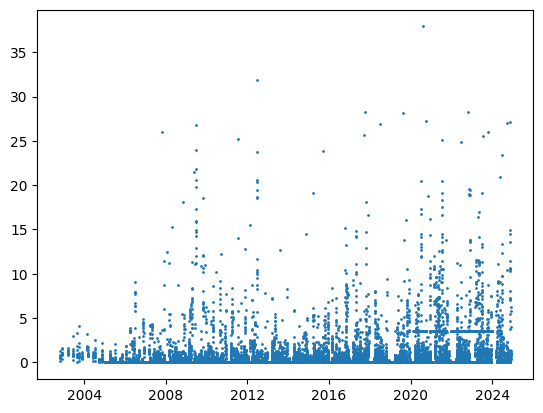

In [140]:
plt.scatter(totalcopy['Start_date'],totalcopy['Nval'],s=1)

In [98]:
import time

In [111]:
xtime = pd.array(data=total['Start_date'])
ynval = pd.array(data=total['Nval'].values)
a = []
for i in range(len(xtime)):
    b = xtime[i].timetuple()
    a.append(time.mktime(b))

In [120]:
xtime = np.array(a).reshape(-1,1)
xtime

array([[1.1950164e+09],
       [1.2362292e+09],
       [1.3608180e+09],
       ...,
       [1.0349136e+09],
       [1.0349136e+09],
       [1.0349136e+09]])

In [121]:
ynval = ynval.astype(np.float64).reshape(-1,1)

In [122]:
xtimescale = scalr.fit_transform(xtime)
ynvalscale = scalr.fit_transform(ynval)

In [129]:

for i in range(len(ynval)):
    if ynval[i]<=0.0:
        c = 1
    else:
        ynval[i] = np.log(ynval[i])

In [131]:
timereg = OLS(ynval,xtimescale).fit()
timereg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.011
Model:                            OLS   Adj. R-squared (uncentered):              0.011
Method:                 Least Squares   F-statistic:                              772.8
Date:                Fri, 11 Apr 2025   Prob (F-statistic):                   3.76e-169
Time:                        17:40:14   Log-Likelihood:                     -1.8251e+05
No. Observations:               70297   AIC:                                  3.650e+05
Df Residuals:                   70296   BIC:                                  3.650e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3403      0.012     27.798      0.000       0.316       0.364
==============================================================================
Omnibus:                    10721.968   Durbin-Watson:                   0.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10463.609
Skew:                          -0.875   Prob(JB):                         0.00
Kurtosis:                       2.287   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

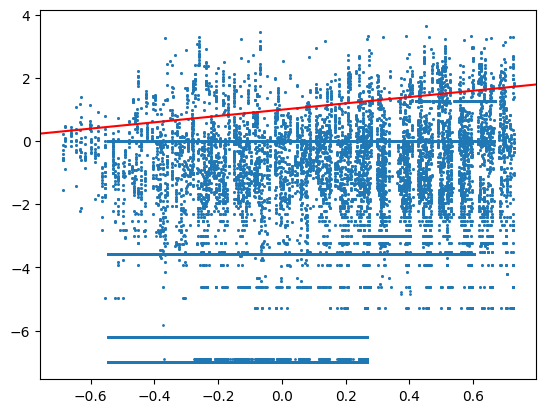

In [137]:
plt.scatter(timereg.predict(),ynval,s=1)
plt.axline(xy1 = [0,1],slope=1,c='r')

In [138]:
timereg = OLS(ynvalscale,xtimescale).fit()
timereg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.037
Model:                            OLS   Adj. R-squared (uncentered):              0.037
Method:                 Least Squares   F-statistic:                              2671.
Date:                Fri, 11 Apr 2025   Prob (F-statistic):                        0.00
Time:                        17:42:59   Log-Likelihood:                         -98436.
No. Observations:               70297   AIC:                                  1.969e+05
Df Residuals:                   70296   BIC:                                  1.969e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1913      0.004     51.685      0.000       0.184       0.199
==============================================================================
Omnibus:                   103267.249   Durbin-Watson:                   0.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         42897910.057
Skew:                           9.009   Prob(JB):                         0.00
Kurtosis:                     122.671   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

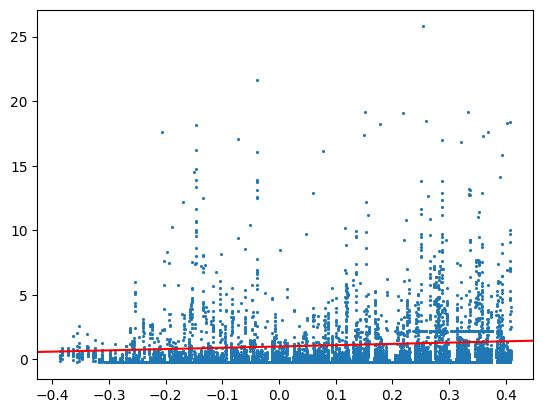

In [139]:
plt.scatter(timereg.predict(),ynvalscale,s=1)
plt.axline(xy1 = [0,1],slope=1,c='r')

These shitty scaled ys!

In [144]:
totalcopy.iloc[0,0].month

11

In [346]:
totalcopy['month'] = 0
for i in range(len(totalcopy)):
    totalcopy.iloc[i,6] = totalcopy.iloc[i,0].month


In [348]:
summer = pd.DataFrame(data=totalcopy)
winter = pd.DataFrame(data=totalcopy)
for i in range(len(totalcopy)):
    if 4<totalcopy.iloc[i,6] < 11:
        winter.drop(i,axis=0,inplace=True)
    else:
        summer.drop(i,axis=0,inplace=True)

In [153]:
summer_n = summer['Nval']
winter_n = winter['Nval']

In [349]:
len(summer)

39330

In [350]:
len(winter)

30967

In [154]:
from scipy import stats

In [157]:
print(stats.ttest_ind(summer_n, winter_n,equal_var=False))
print(stats.ttest_ind(summer_n, winter_n,equal_var=True))

TtestResult(statistic=np.float64(3.129343905040317), pvalue=np.float64(0.0017527753349196853), df=np.float64(62627.21541235116))
TtestResult(statistic=np.float64(3.062819071285307), pvalue=np.float64(0.0021935556721643067), df=np.float64(62641.0))


In [156]:
print(np.mean(summer_n)-np.mean(winter_n))

0.02784300266195905


Positive t stat: values in the summer are significantly higher than values in the winter.

In [352]:
winter.iloc[0,1]

np.float64(0.0)

In [379]:
winter_bmp = pd.merge(winter,per_watershed,on='MonitoringLocationIdentifier',how='left').reset_index().drop('index',axis=1)

In [ ]:
winter_bmp.columns.get_loc('2020')

19

In [406]:
winter_2020 = pd.DataFrame(winter_bmp[winter_bmp['Year']==2020]).dropna().reset_index().drop('index',axis=1)

winter_2020=winter_2020[winter_2020['2020']>0.0]

winter_2021 = pd.DataFrame(winter_bmp[winter_bmp['Year']==2021]).dropna().reset_index().drop('index',axis=1)

winter_2021=winter_2021[winter_2021['2021']>0.0]

winter_2022 = pd.DataFrame(winter_bmp[winter_bmp['Year']==2021]).dropna().reset_index().drop('index',axis=1)

winter_2022=winter_2022[winter_2022['2022']>0.0]



In [407]:
loc_winter_2020 = winter_2020['MonitoringLocationIdentifier'].unique()
loc_winter_2021 = winter_2021['MonitoringLocationIdentifier'].unique()
loc_winter_2022 = winter_2022['MonitoringLocationIdentifier'].unique()

In [408]:
wint_2020s = winter_bmp[winter_bmp['MonitoringLocationIdentifier'].isin(loc_winter_2020)]
wint_2021s = winter_bmp[winter_bmp['MonitoringLocationIdentifier'].isin(loc_winter_2021)]
wint_2022s = winter_bmp[winter_bmp['MonitoringLocationIdentifier'].isin(loc_winter_2022)]

In [403]:


vals_wecare_about_pre2014 = wint_2020s[wint_2020s['Year']<=2020]
vals_wecare_about_pre2014 = wint_2020s[wint_2020s['Year']>=2010]
vals_wecare_about_post2014 = wint_2020s[wint_2020s['Year']>2020]

vals_wecare_about_post2014.set_index('MonitoringLocationIdentifier',inplace=True)
vals_wecare_about_pre2014.set_index('MonitoringLocationIdentifier',inplace=True)

todrop = []
for i in vals_wecare_about_pre2014.index:
    #print(i)
    if i in vals_wecare_about_post2014.index:
     #   print(i)
        be = 'yay!'
    else:
        todrop.append(i)
vals_wecare_about_pre2014.drop(index=todrop,inplace=True)
locz_2021 = list(vals_wecare_about_pre2014.index)
todrop = []
for i in vals_wecare_about_post2014.index:
    if i in vals_wecare_about_pre2014.index:
        be = 'yay!'
    else:
        todrop.append(i)
vals_wecare_about_post2014.drop(index=todrop,inplace=True)

for i in vals_wecare_about_pre2014.index.unique():
    pre = vals_wecare_about_pre2014.loc[i]
    post = vals_wecare_about_post2014.loc[i]
    pre = pre['Nval']
    post = post['Nval']
    t,p = stats.ttest_ind(post,pre)
    print(f'{i}',',', np.round(t,2),',', np.round(p,2))

Dean\s Creek Mouth , -0.22 , 0.83
Charles St. Bridge , 1.65 , 0.11
Lake Street Bridge , -0.54 , 0.59
Boardman Creek , -1.14 , 0.26
Camp Barton , -1.79 , 0.08
Curry Road , 1.12 , 0.27
Outfall of Sewage Plant , 0.83 , 0.41
Salo Drive , -0.48 , 0.63
Salmon Creek Mouth , -0.11 , 0.91
North Ludlowville , 0.58 , 0.57
Tile Kiln Road , -0.8 , 0.43
Genoa , 0.46 , 0.65
Lockerby Hill Road , -0.65 , 0.52
Little Salmon Creek Above Fork , -0.29 , 0.77
Bridge @ Blakley Rd. , -0.15 , 0.89


C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\1139661383.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals_wecare_about_pre2014.drop(index=todrop,inplace=True)
C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\1139661383.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals_wecare_about_post2014.drop(index=todrop,inplace=True)


In [404]:

vals_wecare_about_pre2014 = wint_2021s[wint_2021s['Year']<=2021]
vals_wecare_about_pre2014 = wint_2021s[wint_2021s['Year']>=2010]
vals_wecare_about_post2014 = wint_2021s[wint_2021s['Year']>2021]

vals_wecare_about_post2014.set_index('MonitoringLocationIdentifier',inplace=True)
vals_wecare_about_pre2014.set_index('MonitoringLocationIdentifier',inplace=True)

todrop = []
for i in vals_wecare_about_pre2014.index:
    #print(i)
    if i in vals_wecare_about_post2014.index:
     #   print(i)
        be = 'yay!'
    else:
        todrop.append(i)
vals_wecare_about_pre2014.drop(index=todrop,inplace=True)
locz_2021 = list(vals_wecare_about_pre2014.index)
todrop = []
for i in vals_wecare_about_post2014.index:
    if i in vals_wecare_about_pre2014.index:
        be = 'yay!'
    else:
        todrop.append(i)
vals_wecare_about_post2014.drop(index=todrop,inplace=True)

for i in vals_wecare_about_pre2014.index.unique():
    pre = vals_wecare_about_pre2014.loc[i]
    post = vals_wecare_about_post2014.loc[i]
    pre = pre['Nval']
    post = post['Nval']
    t,p = stats.ttest_ind(post,pre)
    print(f'{i}',',', np.round(t,2),',', np.round(p,2))

Johnsons Creek - Dump , -0.45 , 0.66
Johnsons Creek Mouth-Deans Cove , -0.25 , 0.81
Johnsons Creek Gully , -0.58 , 0.57
Paines Creek Rafferty Road , 1.22 , 0.23
Mill Creek Mouth , 2.36 , 0.02
Paines Creek Moonshine , 1.49 , 0.15
Dean\s Creek Mouth , 0.44 , 0.66
Paines Creek Mouth , 1.73 , 0.09
Charles St. Bridge , 1.53 , 0.14
Lake Street Bridge , -0.75 , 0.46
Boardman Creek , -1.33 , 0.19
Camp Barton , -1.63 , 0.11
Curry Road , 0.53 , 0.6
Outfall of Sewage Plant , 1.07 , 0.29
Salo Drive , -0.67 , 0.51
Glen Eldridge Creek Mouth , -1.99 , 0.08
Canoga Creek South Branch , -1.48 , 0.17
Canoga Creek North Branch , -0.9 , 0.39
Burroughs Creek , -1.84 , 0.09
Salmon Creek Mouth , -1.18 , 0.25
North Ludlowville , -2.06 , 0.05
Locke Creek , -2.09 , 0.05
Tile Kiln Road , -2.72 , 0.01
Genoa , -1.98 , 0.06
Lockerby Hill Road , -2.41 , 0.03
Little Salmon Creek Above Fork , -2.41 , 0.03
Bridge @ Blakley Rd. , -1.93 , 0.08


C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\1464812451.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals_wecare_about_pre2014.drop(index=todrop,inplace=True)
C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\1464812451.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals_wecare_about_post2014.drop(index=todrop,inplace=True)
c:\Users\lilyd\anaconda3\envs\xarray_env\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypote

In [409]:

vals_wecare_about_pre2014 = wint_2022s[wint_2022s['Year']<=2022]
vals_wecare_about_pre2014 = wint_2022s[wint_2022s['Year']>=2010]
vals_wecare_about_post2014 = wint_2022s[wint_2022s['Year']>2022]

vals_wecare_about_post2014.set_index('MonitoringLocationIdentifier',inplace=True)
vals_wecare_about_pre2014.set_index('MonitoringLocationIdentifier',inplace=True)

todrop = []
for i in vals_wecare_about_pre2014.index:
    #print(i)
    if i in vals_wecare_about_post2014.index:
     #   print(i)
        be = 'yay!'
    else:
        todrop.append(i)
vals_wecare_about_pre2014.drop(index=todrop,inplace=True)
locz_2021 = list(vals_wecare_about_pre2014.index)
todrop = []
for i in vals_wecare_about_post2014.index:
    if i in vals_wecare_about_pre2014.index:
        be = 'yay!'
    else:
        todrop.append(i)
vals_wecare_about_post2014.drop(index=todrop,inplace=True)

for i in vals_wecare_about_pre2014.index.unique():
    pre = vals_wecare_about_pre2014.loc[i]
    post = vals_wecare_about_post2014.loc[i]
    pre = pre['Nval']
    post = post['Nval']
    t,p = stats.ttest_ind(post,pre)
    print(f'{i}',',', np.round(t,2),',', np.round(p,2))

Fall Creek Forest Home , -0.44 , 0.67
Fall Creek Freeville , -1.38 , 0.17
Freese Road Bridge , -1.49 , 0.14
McLean Rd. , -0.97 , 0.34
Cayuga Street Bridge , -1.6 , 0.11
Lafayette Road , -0.02 , 0.98
Davis Road Bridge , -1.04 , 0.3
Como Lake Outlet , -0.0 , 1.0
Charles St. Bridge , 1.53 , 0.14
Bridge at Route 14 , -2.17 , 0.04
Glen Eldridge Creek Mouth , -1.99 , 0.08


C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\2277705483.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals_wecare_about_pre2014.drop(index=todrop,inplace=True)
C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\2277705483.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals_wecare_about_post2014.drop(index=todrop,inplace=True)
c:\Users\lilyd\anaconda3\envs\xarray_env\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypote

In [411]:
summer_bmp = pd.merge(summer,per_watershed,on='MonitoringLocationIdentifier',how='left').reset_index().drop('index',axis=1)

In [419]:
summer_2020 = pd.DataFrame(summer_bmp[summer_bmp['Year']==2020]).dropna().reset_index().drop('index',axis=1)

summer_2020=summer_2020[summer_2020['2020']>0.0]

summer_2021 = pd.DataFrame(summer_bmp[summer_bmp['Year']==2021]).dropna().reset_index().drop('index',axis=1)

summer_2021=summer_2021[summer_2021['2021']>0.0]

summer_2022 = pd.DataFrame(summer_bmp[summer_bmp['Year']==2021]).dropna().reset_index().drop('index',axis=1)

summer_2022=summer_2022[summer_2022['2022']>0.0]


In [421]:
loc_snter_2020 = summer_2020['MonitoringLocationIdentifier'].unique()
loc_snter_2021 = summer_2021['MonitoringLocationIdentifier'].unique()
loc_snter_2022 = summer_2022['MonitoringLocationIdentifier'].unique()
s2020 = summer_bmp[summer_bmp['MonitoringLocationIdentifier'].isin(loc_snter_2020)]
s2021 = summer_bmp[summer_bmp['MonitoringLocationIdentifier'].isin(loc_snter_2021)]
s2022 = summer_bmp[summer_bmp['MonitoringLocationIdentifier'].isin(loc_snter_2022)]

In [422]:

vals_wecare_about_pre2014 = s2020[s2020['Year']<=2020]
vals_wecare_about_pre2014 = s2020[s2020['Year']>=2010]
vals_wecare_about_post2014 = s2020[s2020['Year']>2021]

vals_wecare_about_post2014.set_index('MonitoringLocationIdentifier',inplace=True)
vals_wecare_about_pre2014.set_index('MonitoringLocationIdentifier',inplace=True)

todrop = []
for i in vals_wecare_about_pre2014.index:
    #print(i)
    if i in vals_wecare_about_post2014.index:
     #   print(i)
        be = 'yay!'
    else:
        todrop.append(i)
vals_wecare_about_pre2014.drop(index=todrop,inplace=True)
locz_2021 = list(vals_wecare_about_pre2014.index)
todrop = []
for i in vals_wecare_about_post2014.index:
    if i in vals_wecare_about_pre2014.index:
        be = 'yay!'
    else:
        todrop.append(i)
vals_wecare_about_post2014.drop(index=todrop,inplace=True)

for i in vals_wecare_about_pre2014.index.unique():
    pre = vals_wecare_about_pre2014.loc[i]
    post = vals_wecare_about_post2014.loc[i]
    pre = pre['Nval']
    post = post['Nval']
    t,p = stats.ttest_ind(post,pre)
    print(f'{i}',',', np.round(t,2),',', np.round(p,2))

C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\1734670953.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals_wecare_about_pre2014.drop(index=todrop,inplace=True)
C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\1734670953.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals_wecare_about_post2014.drop(index=todrop,inplace=True)


Burroughs Creek , 0.48 , 0.63
Little Salmon Creek Above Fork , -0.15 , 0.88
Tile Kiln Road , -0.06 , 0.95
Genoa , -0.21 , 0.83
Lockerby Hill Road , -0.13 , 0.89
North Ludlowville , -0.19 , 0.85
Salmon Creek Mouth , -0.35 , 0.73
Bridge @ Blakley Rd. , -0.68 , 0.5
Keuka Outlet - Downstream of Wastewater Plant , 1.23 , 0.23
Keuka Outlet Birkett Mills , -0.91 , 0.37
Keuka Outlet @ Indian Pines Park , -0.11 , 0.91
Fox\s Mill Rd. , -0.86 , 0.39
Charles St. Bridge , -0.9 , 0.37
Boardman Creek , -1.91 , 0.06
Outfall of Sewage Plant , 2.47 , 0.02
Salo Drive , -1.68 , 0.1
Lake Street Bridge , -1.72 , 0.09
Curry Road , -1.71 , 0.09
Camp Barton , 1.53 , 0.13
Middle of Lake Opposite Mouth of Salmon Creek (E) , -0.4 , 0.69
Middle of Lake Opposite Mouth of Salmon Creek (H) , 0.97 , 0.34
Yawger Creek Townline West , 0.02 , 0.98
Yawger Creek Mouth , -0.63 , 0.53
Yawger Creek @ Cork & Townline , -0.66 , 0.52
Yawger Creek Large Ridge , -0.33 , 0.74
Mill Creek Mouth , -0.97 , 0.34
Dean\s Creek Mouth , -1.

In [423]:
s2021

,Start_date,Nval,Ntype,MonitoringLocationIdentifier,Year,bmp,month,Name,AREA,PERCENTAGE,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
29616,2024-10-22,0.005,mg/l as N,Canoga Creek South Branch,2024,0.0,10,Canoga Creek South Branch,8.159250e+06,7.763383,...,0.000000,8.832214,0.000000,0.0,0.0,0.0,0.000000,312.041405,0.000000,0.000000
29617,2024-10-22,0.030,mg/l as N,Canoga Creek North Branch,2024,0.0,10,Canoga Creek North Branch,6.002164e+06,5.710954,...,0.000000,6.497215,0.000000,0.0,0.0,0.0,0.000000,229.546079,0.000000,0.000000
29618,2024-10-22,0.005,mg/l as N,Burroughs Creek,2024,0.0,10,Burroughs Creek,7.646599e+06,5.204132,...,0.000000,0.000000,1.715969,0.0,0.0,0.0,139.476869,15.688115,0.000000,0.000000
29619,2024-10-16,0.630,mg/l as N,Little Salmon Creek Above Fork,2024,0.0,10,Little Salmon Creek Above Fork,3.566083e+07,27.586757,...,10599.588742,16228.091334,0.000000,0.0,0.0,0.0,5881.694548,6098.521716,9.042939,0.000000
29621,2024-10-16,0.430,mg/l as N,Tile Kiln Road,2024,0.0,10,Tile Kiln Road,3.983602e+07,30.816631,...,11840.594885,18128.085903,0.000000,0.0,0.0,0.0,6570.326837,6812.540260,10.101692,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39203,2006-05-10,2.120,mg/l as N,Genoa,2006,0.0,5,Genoa,7.349288e+07,56.853145,...,21844.537406,33444.236074,0.000000,0.0,0.0,0.0,12121.498266,12568.354207,18.636461,0.000000
39205,2006-05-10,2.420,mg/l as N,Lockerby Hill Road,2006,0.0,5,Lockerby Hill Road,1.595471e+08,129.784680,...,38402.461654,58794.607069,0.000000,0.0,0.0,0.0,21309.463492,30909.790845,37.653058,9.694679
39206,2006-05-10,1.810,mg/l as N,Locke Creek,2006,0.0,5,Locke Creek,2.665537e+07,26.207503,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,7742.375285,4.295410,8.515246
39207,2006-05-10,2.070,mg/l as N,North Ludlowville,2006,0.0,5,North Ludlowville,2.088478e+08,178.257057,...,38402.461654,58794.607069,0.000000,0.0,0.0,0.0,21309.463492,45229.786286,45.597680,25.444145


In [424]:

vals_wecare_about_pre2014 = s2021[s2021['Year']<=2021]
vals_wecare_about_pre2014 = s2021[s2021['Year']>=2010]
vals_wecare_about_post2014 = s2021[s2021['Year']>2021]

vals_wecare_about_post2014.set_index('MonitoringLocationIdentifier',inplace=True)
vals_wecare_about_pre2014.set_index('MonitoringLocationIdentifier',inplace=True)

todrop = []
for i in vals_wecare_about_pre2014.index:
    #print(i)
    if i in vals_wecare_about_post2014.index:
     #   print(i)
        be = 'yay!'
    else:
        todrop.append(i)
vals_wecare_about_pre2014.drop(index=todrop,inplace=True)
locz_2021 = list(vals_wecare_about_pre2014.index)
todrop = []
for i in vals_wecare_about_post2014.index:
    if i in vals_wecare_about_pre2014.index:
        be = 'yay!'
    else:
        todrop.append(i)
vals_wecare_about_post2014.drop(index=todrop,inplace=True)

for i in vals_wecare_about_pre2014.index.unique():
    pre = vals_wecare_about_pre2014.loc[i]
    post = vals_wecare_about_post2014.loc[i]
    pre = pre['Nval']
    post = post['Nval']
    t,p = stats.ttest_ind(post,pre)
    print(f'{i}',',', np.round(t,2),',', np.round(p,2))

Canoga Creek South Branch , -0.64 , 0.53
Canoga Creek North Branch , -0.92 , 0.37
Burroughs Creek , 0.48 , 0.63
Little Salmon Creek Above Fork , -0.15 , 0.88
Tile Kiln Road , -0.06 , 0.95
Genoa , -0.21 , 0.83
Lockerby Hill Road , -0.13 , 0.89
North Ludlowville , -0.19 , 0.85
Salmon Creek Mouth , -0.35 , 0.73
Locke Creek , -0.58 , 0.56
Bridge @ Blakley Rd. , -0.68 , 0.5
Glen Eldridge Creek Mouth , -0.88 , 0.38
Keuka Outlet - Downstream of Wastewater Plant , 1.23 , 0.23
Keuka Outlet Birkett Mills , -0.91 , 0.37
Keuka Outlet @ Jacob Creek , -0.82 , 0.42
Fox\s Mill Rd. , -0.86 , 0.39
Charles St. Bridge , -0.9 , 0.37
Boardman Creek , -1.91 , 0.06
Outfall of Sewage Plant , 2.47 , 0.02
Salo Drive , -1.68 , 0.1
Lake Street Bridge , -1.72 , 0.09
Curry Road , -1.71 , 0.09
Camp Barton , 1.53 , 0.13
Middle of Lake Opposite Mouth of Salmon Creek (E) , -0.4 , 0.69
Middle of Lake Opposite Mouth of Salmon Creek (H) , 0.97 , 0.34
Yawger Creek Townline West , 0.02 , 0.98
Yawger Creek Mouth , -0.63 , 0.5

C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\3299752893.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals_wecare_about_pre2014.drop(index=todrop,inplace=True)
C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\3299752893.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals_wecare_about_post2014.drop(index=todrop,inplace=True)
c:\Users\lilyd\anaconda3\envs\xarray_env\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypote

In [425]:

vals_wecare_about_pre2014 = s2022[s2022['Year']<=2022]
vals_wecare_about_pre2014 = s2022[s2022['Year']>=2010]
vals_wecare_about_post2014 = s2022[s2022['Year']>2022]

vals_wecare_about_post2014.set_index('MonitoringLocationIdentifier',inplace=True)
vals_wecare_about_pre2014.set_index('MonitoringLocationIdentifier',inplace=True)

todrop = []
for i in vals_wecare_about_pre2014.index:
    #print(i)
    if i in vals_wecare_about_post2014.index:
     #   print(i)
        be = 'yay!'
    else:
        todrop.append(i)
vals_wecare_about_pre2014.drop(index=todrop,inplace=True)
locz_2021 = list(vals_wecare_about_pre2014.index)
todrop = []
for i in vals_wecare_about_post2014.index:
    if i in vals_wecare_about_pre2014.index:
        be = 'yay!'
    else:
        todrop.append(i)
vals_wecare_about_post2014.drop(index=todrop,inplace=True)

for i in vals_wecare_about_pre2014.index.unique():
    pre = vals_wecare_about_pre2014.loc[i]
    post = vals_wecare_about_post2014.loc[i]
    pre = pre['Nval']
    post = post['Nval']
    t,p = stats.ttest_ind(post,pre)
    print(f'{i}',',', np.round(t,2),',', np.round(p,2))

Little Salmon Creek Above Fork , 0.47 , 0.64
Tile Kiln Road , 0.58 , 0.56
Genoa , 0.56 , 0.58
Lockerby Hill Road , 0.63 , 0.53
North Ludlowville , 0.51 , 0.62
Salmon Creek Mouth , 0.26 , 0.79
Locke Creek , -0.25 , 0.8
Bridge @ Blakley Rd. , 0.03 , 0.98
Glen Eldridge Creek Mouth , -1.41 , 0.16
Keuka Outlet - Downstream of Wastewater Plant , 1.37 , 0.19
Keuka Outlet Birkett Mills , -0.62 , 0.54
Keuka Outlet @ Indian Pines Park , -0.32 , 0.75
Fox\s Mill Rd. , -0.77 , 0.44
Charles St. Bridge , -0.8 , 0.43
Middle of Lake Opposite Mouth of Salmon Creek (E) , 0.67 , 0.5
Middle of Lake Opposite Mouth of Salmon Creek (H) , 1.34 , 0.18
Yawger Creek Townline West , 0.39 , 0.7
Yawger Creek Mouth , 0.21 , 0.83
Yawger Creek @ Cork & Townline , 0.25 , 0.81
Yawger Creek Large Ridge , 0.88 , 0.39
McLean Rd. , 1.39 , 0.17
Fall Creek Forest Home , 0.71 , 0.48
Cayuga Street Bridge , -0.08 , 0.94
Freese Road Bridge , 0.5 , 0.62
Fall Creek Freeville , 1.06 , 0.29
Davis Road Bridge , 2.35 , 0.02
Lafayette Ro

C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\1149966590.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals_wecare_about_pre2014.drop(index=todrop,inplace=True)
C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\1149966590.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals_wecare_about_post2014.drop(index=todrop,inplace=True)
c:\Users\lilyd\anaconda3\envs\xarray_env\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypote

In [436]:
sumloc = np.array(list(loc_snter_2020)+list(loc_snter_2021)+list(loc_snter_2022))
winloc = pd.array(list(loc_winter_2020)+list(loc_winter_2021)+list(loc_winter_2022))

In [439]:
lisst = []
for i in sumloc:
    if i in (winloc):
        lisst.append(i)
        wninn=winter_bmp[winter_bmp['MonitoringLocationIdentifier']==i]
        sunin = summer_bmp[summer_bmp['MonitoringLocationIdentifier']==i]
        win=wninn['Nval']
        sun=sunin['Nval']
        t,p = stats.ttest_ind(win,sun)
        print(f'{i}',',', np.round(t,2),',', np.round(p,2))       

East Branch Shallow , 4.54 , 0.0
East Branch Deep , -1.46 , 0.15
East thermocline depth , 3.76 , 0.0
Keuka Outlet @ Indian Pines Park , 4.53 , 0.0
Keuka Outlet Birkett Mills , 2.72 , 0.01
Fox\s Mill Rd. , -0.34 , 0.74
Charles St. Bridge , -0.28 , 0.78
Keuka Outlet - Downstream of Wastewater Plant , 1.81 , 0.09
Camp Barton , -3.51 , 0.0
Outfall of Sewage Plant , -5.44 , 0.0
Boardman Creek , 2.61 , 0.01
Salo Drive , 3.11 , 0.0
Curry Road , 0.22 , 0.83
Lake Street Bridge , 3.86 , 0.0
Salmon Creek Mouth , 3.65 , 0.0
North Ludlowville , 3.55 , 0.0
Lockerby Hill Road , 2.72 , 0.01
Genoa , 2.89 , 0.01
Tile Kiln Road , 1.56 , 0.12
Bridge @ Blakley Rd. , 3.4 , 0.0
Little Salmon Creek Above Fork , 3.09 , 0.0
Dean\s Creek Mouth , -2.52 , 0.01
Mill Creek Mouth , -2.34 , 0.02
Burroughs Creek , -1.73 , 0.09
Canoga Creek South Branch , -0.99 , 0.33
Canoga Creek North Branch , -0.65 , 0.52
Burroughs Creek , -1.73 , 0.09
Locke Creek , 2.1 , 0.04
Salmon Creek Mouth , 3.65 , 0.0


c:\Users\lilyd\anaconda3\envs\xarray_env\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Little Salmon Creek Above Fork , 3.09 , 0.0
Bridge @ Blakley Rd. , 3.4 , 0.0
Tile Kiln Road , 1.56 , 0.12
Genoa , 2.89 , 0.01
Lockerby Hill Road , 2.72 , 0.01
North Ludlowville , 3.55 , 0.0
Curry Road , 0.22 , 0.83
Boardman Creek , 2.61 , 0.01
Camp Barton , -3.51 , 0.0
Salo Drive , 3.11 , 0.0
Outfall of Sewage Plant , -5.44 , 0.0
Lake Street Bridge , 3.86 , 0.0
Charles St. Bridge , -0.28 , 0.78
Keuka Outlet Birkett Mills , 2.72 , 0.01
Keuka Outlet @ Jacob Creek , 2.96 , 0.01
Paines Creek Mouth , -0.65 , 0.52
Mill Creek Mouth , -2.34 , 0.02
Dean\s Creek Mouth , -2.52 , 0.01
Paines Creek Moonshine , -1.86 , 0.07
Johnsons Creek Mouth-Deans Cove , 0.95 , 0.35
Johnsons Creek - Dump , 2.87 , 0.01
Johnsons Creek Gully , 0.64 , 0.53
Catharine Creek @ Seneca Lake , 2.4 , 0.02
Glen Eldridge Creek Mouth , -0.04 , 0.97
Keuka Outlet - Downstream of Wastewater Plant , 1.81 , 0.09
Fox\s Mill Rd. , -0.34 , 0.74
Paines Creek Rafferty Road , 0.47 , 0.64
McLean Rd. , 5.79 , 0.0
McLean Bridge , 7.59 , 0.0

In [442]:
len(np.unique(lisst))

47

# END PLAY

In [83]:
total
per_watershed.reset_index(inplace=True)
per_watershed['MonitoringLocationIdentifier'] = per_watershed['Name']

In [143]:
total

,Start_date,Nval,Ntype,MonitoringLocationIdentifier
0,2007-11-14,0.000000,mg/l,USGS-01311992
1,2009-03-05,0.000904,mg/l,USGS-01311992
2,2013-02-14,0.000000,mg/l,USGS-01311992
3,2009-12-14,0.000904,mg/l,USGS-01311992
4,2006-06-14,0.000000,mg/l,USGS-01311992
...,...,...,...,...
70292,2002-10-18,0.750000,mg/l as N,Virgil Creek Road
70293,2002-10-18,0.590000,mg/l as N,Spring House Bridge
70294,2002-10-18,0.660000,mg/l as N,Virgil Creek Freeville
70295,2002-10-18,0.560000,mg/l as N,Freese Road Bridge


In [92]:
per_watershed

,Name,AREA,PERCENTAGE,prop,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,MonitoringLocationIdentifier
0,21NYDECA_WQX-01021067,3.779880e+07,63.985529,0.639855,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,21NYDECA_WQX-01021067
1,21NYDECA_WQX-01021103,4.471417e+08,709.806190,7.098062,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,21NYDECA_WQX-01021103
2,21NYDECA_WQX-01031002,1.110528e+09,1674.143782,16.741438,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,21NYDECA_WQX-01031002
3,21NYDECA_WQX-01033101,1.450917e+08,199.413283,1.994133,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,21NYDECA_WQX-01033101
4,21NYDECA_WQX-01033200,1.802364e+08,299.714903,2.997149,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,21NYDECA_WQX-01033200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,Yawger Creek Large Ridge,2.246462e+07,34.829505,0.348295,7341.202953,0.0,0.0,0.0,0.0,0.0,0.0,0.825037,4899.780004,6.239321,0.0,Yawger Creek Large Ridge
882,Yawger Creek Mouth,6.322871e+07,98.030775,0.980308,20662.475741,0.0,0.0,0.0,0.0,0.0,0.0,2.322139,13790.871348,17.561130,0.0,Yawger Creek Mouth
883,Yawger Creek North Branch,1.826784e+07,28.322752,0.283228,5969.739440,0.0,0.0,0.0,0.0,0.0,0.0,0.670905,3984.416467,5.073708,0.0,Yawger Creek North Branch
884,Yawger Creek South Cross Road,3.392514e+07,52.598074,0.525981,11086.380140,0.0,0.0,0.0,0.0,0.0,0.0,1.245936,7399.444488,9.422364,0.0,Yawger Creek South Cross Road


In [84]:
vals_with_bmp = pd.merge(total,per_watershed,on='MonitoringLocationIdentifier',how='left')

In [160]:
vals_with_bmp['Nval'].isnull().any()

np.False_

Ok so the NA vals are just where the bmp data isn't available.

In [ ]:
nona = vals_with_bmp.dropna().reset_index().drop(['index'],axis=1)
nona
filln = vals_with_bmp.fillna(0.0)


,Start_date,Nval,Ntype,MonitoringLocationIdentifier,Name,AREA,PERCENTAGE,prop,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,2007-11-14,0.000000,mg/l,USGS-01311992,USGS-01311992,3.491607e+06,5.794236,0.057942,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
1,2009-03-05,0.000904,mg/l,USGS-01311992,USGS-01311992,3.491607e+06,5.794236,0.057942,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2,2013-02-14,0.000000,mg/l,USGS-01311992,USGS-01311992,3.491607e+06,5.794236,0.057942,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
3,2009-12-14,0.000904,mg/l,USGS-01311992,USGS-01311992,3.491607e+06,5.794236,0.057942,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
4,2006-06-14,0.000000,mg/l,USGS-01311992,USGS-01311992,3.491607e+06,5.794236,0.057942,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70292,2002-10-18,0.750000,mg/l as N,Virgil Creek Road,Virgil Creek Road,4.212841e+07,99.909864,0.999099,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
70293,2002-10-18,0.590000,mg/l as N,Spring House Bridge,Spring House Bridge,8.007188e+07,160.126088,1.601261,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
70294,2002-10-18,0.660000,mg/l as N,Virgil Creek Freeville,Virgil Creek Freeville,1.050945e+08,199.834873,1.998349,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
70295,2002-10-18,0.560000,mg/l as N,Freese Road Bridge,Freese Road Bridge,3.223944e+08,481.622819,4.816228,0.0,0.0,0.0,2.357526,0.0,0.0,0.0,0.0,0.0,10147.71018,0.0


In [161]:
grouped = nona.groupby('MonitoringLocationIdentifier')
groupedf = filln.groupby('MonitoringLocationIdentifier')

# Create a dictionary to store each location's DataFrame
dfs = {location: group for location, group in grouped}

In [164]:
len(dfs) #338 locations
#how to associate the bmp load colums with years to do a plot. that should be ok but annoying


338

In [188]:
loc_reds = pd.DataFrame(filln)
loc_reds.drop(['Name','PERCENTAGE','AREA','Ntype','Nval','Start_date','prop'],axis=1,inplace=True)

In [177]:
df_long = loc_reds.melt(id_vars=['MonitoringLocationIdentifier'], var_name='Year', value_name='Value')

# Convert 'Year' column to a datetime type (optional, but useful for time series)
df_long['Year'] = pd.to_datetime(df_long['Year'], format='%Y')

# Set 'Year' as the index to create a time series
df_long.set_index(['MonitoringLocationIdentifier', 'Year'], inplace=True)

print("\nReshaped DataFrame (Time Series):")


Reshaped DataFrame (Time Series):


In [178]:
import matplotlib.pyplot as plt

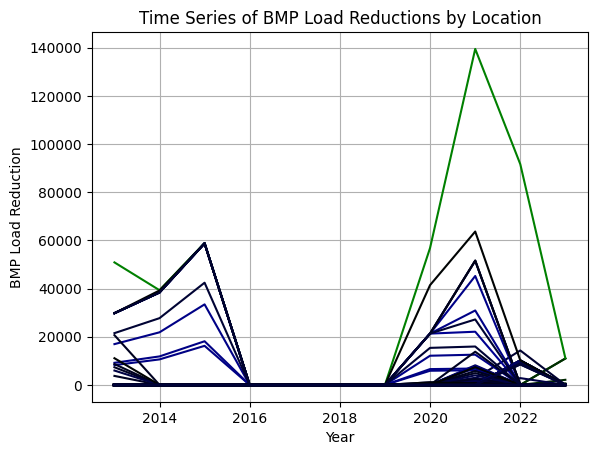

In [185]:

# Plot time series for each location
#df_long.reset_index(inplace=True)  # Optional: Flatten the multi-index to make it easier to plot

# Loop through each location and plot its time series
a='00'
an=0
for location in df_long['MonitoringLocationIdentifier'].unique():
    if an<100:
        hexc = '#00'+a+'00'
    else:
        hexc = '#000'+a
    loc_data = df_long[df_long['MonitoringLocationIdentifier'] == location]
    plt.plot(loc_data['Year'], loc_data['Value'], label=location,c=hexc)
    an+=1
    if an<10:
        a='0' + str(an)
    else:
        a=str(an)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('BMP Load Reduction')
plt.title('Time Series of BMP Load Reductions by Location')
#plt.legend(title='Location')
plt.grid(True)

# Show plot
plt.show()

I guess now I can do a comparison: n samples before with mean u1 and std o1; m samples after with mean u2 and std o2

For this I think we should use a 2 sample t test. i'll just use scipys functions

In [294]:
site_2021 = loc_reds.groupby('MonitoringLocationIdentifier').agg('sum')['2021']
site_2021 = pd.DataFrame(site_2021)
site_2021 = site_2021[site_2021['2021']>0.0]
site_2022 = loc_reds.groupby('MonitoringLocationIdentifier').agg('sum')['2022']
site_2022 = pd.DataFrame(site_2022)
site_2022 = site_2022[site_2022['2022']>0.0]
site_2020 = loc_reds.groupby('MonitoringLocationIdentifier').agg('sum')['2020']
site_2020 = pd.DataFrame(site_2020)
site_2020 = site_2020[site_2020['2020']>0.0]
site_2019 = loc_reds.groupby('MonitoringLocationIdentifier').agg('sum')['2019']
site_2019 = pd.DataFrame(site_2019)
site_2019 = site_2019[site_2019['2019']>0.0]

57 sites in 2021. 60 in 2022. 48 in 2020.

Do we: choose 2020 because we're likely to have more samples 2021 or later?

In [253]:
len(site_2019)

2

In [307]:
locs_2020 = list(site_2020.index)
vals_wecare_about = filln[filln['MonitoringLocationIdentifier'].isin(locs_2020)]
#vals_wecare_about.drop('index',axis=1,inplace=True)

for i in range(len(vals_wecare_about)):
    vals_wecare_about.iloc[i,0] = vals_wecare_about.iloc[i,0].year

vals_wecare_about_pre2020 = vals_wecare_about[vals_wecare_about['Start_date']<=2020]
vals_wecare_about_pre2020 = vals_wecare_about_pre2020[vals_wecare_about_pre2020['Start_date']>=2010]
vals_wecare_about_post2020 = vals_wecare_about[vals_wecare_about['Start_date']>2020]


C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\2969938730.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2007' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  vals_wecare_about.iloc[i,0] = vals_wecare_about.iloc[i,0].year


In [308]:
vals_wecare_about_post2020.set_index('MonitoringLocationIdentifier',inplace=True)
vals_wecare_about_pre2020.set_index('MonitoringLocationIdentifier',inplace=True)

In [309]:
todrop = []
for i in vals_wecare_about_pre2020.index:
    print(i)
    if i in vals_wecare_about_post2020.index:
        print(i)
        be = 'yay!'
    else:
        todrop.append(i)
vals_wecare_about_pre2020.drop(index=todrop,inplace=True)

21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
21NYDECA_WQX-07010005
USGS-425606076251601
USGS-425606076251601
USGS-425606076251601
USGS-425606076251601
USGS-425606076251601
USGS-425606076251601
USGS-425606076251601
USGS-425606076251601
USGS-425606076251601
USGS-425606076251601
USGS-425606076251601
USGS-425606076251601
USGS-425606076251601
USGS-425606076251601
USGS-425606076251601
USGS-425606076251601
USGS-425606076251601
USGS-425606076251601
USGS-425606076251601
USGS-42

In [310]:
todrop = []
for i in vals_wecare_about_post2020.index:
    if i in vals_wecare_about_pre2020.index:
        be = 'yay!'
    else:
        todrop.append(i)
vals_wecare_about_post2020.drop(index=todrop,inplace=True)

C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\163450079.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals_wecare_about_post2020.drop(index=todrop,inplace=True)


In [311]:
locz_2020 = list(vals_wecare_about_post2020.index)

In [312]:
for i in vals_wecare_about_pre2020.index.unique():
    pre = vals_wecare_about_pre2020.loc[i]
    post = vals_wecare_about_post2020.loc[i]
    pre = pre['Nval']
    post = post['Nval']
    t,p = stats.ttest_ind(post,pre)
    print('For', f'{i}', 'the t-stat and p-statistic are ', np.round(t,2),',', np.round(p,2))

For Dean\s Creek Mouth the t-stat and p-statistic are  -0.43 , 0.67
For Genoa the t-stat and p-statistic are  0.26 , 0.8
For Bridge @ Blakley Rd. the t-stat and p-statistic are  -0.37 , 0.71
For Little Salmon Creek Above Fork the t-stat and p-statistic are  -0.36 , 0.72
For Salmon Creek Mouth the t-stat and p-statistic are  -0.78 , 0.44
For North Ludlowville the t-stat and p-statistic are  0.44 , 0.66
For Lockerby Hill Road the t-stat and p-statistic are  0.24 , 0.81
For Tile Kiln Road the t-stat and p-statistic are  0.32 , 0.75
For Camp Barton the t-stat and p-statistic are  2.09 , 0.04
For Curry Road the t-stat and p-statistic are  -0.92 , 0.36
For Outfall of Sewage Plant the t-stat and p-statistic are  2.78 , 0.01
For Salo Drive the t-stat and p-statistic are  0.12 , 0.9
For Lake Street Bridge the t-stat and p-statistic are  0.05 , 0.96
For Boardman Creek the t-stat and p-statistic are  -0.66 , 0.51
For Yawger Creek North Branch the t-stat and p-statistic are  1.57 , 0.14
For Yawger

In [313]:
for i in vals_wecare_about_pre2020.index.unique():
    pre = vals_wecare_about_pre2020.loc[i]
    post = vals_wecare_about_post2020.loc[i]
    pre = pre['Nval']
    post = post['Nval']
    t,p = stats.ttest_ind(post,pre)
    print(f'{i}',',', np.round(t,2),',', np.round(p,2))

Dean\s Creek Mouth , -0.43 , 0.67
Genoa , 0.26 , 0.8
Bridge @ Blakley Rd. , -0.37 , 0.71
Little Salmon Creek Above Fork , -0.36 , 0.72
Salmon Creek Mouth , -0.78 , 0.44
North Ludlowville , 0.44 , 0.66
Lockerby Hill Road , 0.24 , 0.81
Tile Kiln Road , 0.32 , 0.75
Camp Barton , 2.09 , 0.04
Curry Road , -0.92 , 0.36
Outfall of Sewage Plant , 2.78 , 0.01
Salo Drive , 0.12 , 0.9
Lake Street Bridge , 0.05 , 0.96
Boardman Creek , -0.66 , 0.51
Yawger Creek North Branch , 1.57 , 0.14
Yawger Creek @ Cork & Townline , 1.3 , 0.2
Yawger Creek Mouth , 0.86 , 0.39
Yawger Creek Townline West , 0.93 , 0.36
Yawger Creek Large Ridge , 1.53 , 0.13
East Branch Shallow , 1.02 , 0.31
East Branch Deep , -2.18 , 0.03
East thermocline depth , 0.66 , 0.51
Keuka Outlet @ Indian Pines Park , -0.6 , 0.55
Keuka Outlet Birkett Mills , -0.89 , 0.38
Fox\s Mill Rd. , -0.96 , 0.34
Charles St. Bridge , -0.39 , 0.7
Keuka Outlet - Downstream of Wastewater Plant , 0.82 , 0.43
Middle of Lake Opposite Mouth of Salmon Creek (E)

2021

In [318]:
locs_2021 = list(site_2021.index)
vals_wecare_about = filln[filln['MonitoringLocationIdentifier'].isin(locs_2021)]
#vals_wecare_about.drop('index',axis=1,inplace=True)

for i in range(len(vals_wecare_about)):
    vals_wecare_about.iloc[i,0] = vals_wecare_about.iloc[i,0].year

vals_wecare_about_pre2014 = vals_wecare_about[vals_wecare_about['Start_date']<=2021]
vals_wecare_about_pre2014 = vals_wecare_about_pre2014[vals_wecare_about_pre2014['Start_date']>=2010]
vals_wecare_about_post2014 = vals_wecare_about[vals_wecare_about['Start_date']>2021]

vals_wecare_about_post2014.set_index('MonitoringLocationIdentifier',inplace=True)
vals_wecare_about_pre2014.set_index('MonitoringLocationIdentifier',inplace=True)

todrop = []
for i in vals_wecare_about_pre2014.index:
    #print(i)
    if i in vals_wecare_about_post2014.index:
     #   print(i)
        be = 'yay!'
    else:
        todrop.append(i)
vals_wecare_about_pre2014.drop(index=todrop,inplace=True)
locz_2021 = list(vals_wecare_about_pre2014.index)
todrop = []
for i in vals_wecare_about_post2014.index:
    if i in vals_wecare_about_pre2014.index:
        be = 'yay!'
    else:
        todrop.append(i)
vals_wecare_about_post2014.drop(index=todrop,inplace=True)

for i in vals_wecare_about_pre2014.index.unique():
    pre = vals_wecare_about_pre2014.loc[i]
    post = vals_wecare_about_post2014.loc[i]
    pre = pre['Nval']
    post = post['Nval']
    t,p = stats.ttest_ind(post,pre)
    print(f'{i}',',', np.round(t,2),',', np.round(p,2))

C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\3698436244.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2013' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  vals_wecare_about.iloc[i,0] = vals_wecare_about.iloc[i,0].year
C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\3698436244.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals_wecare_about_post2014.drop(index=todrop,inplace=True)


Canoga Creek North Branch , -1.21 , 0.24
Canoga Creek South Branch , -0.86 , 0.39
Burroughs Creek , 1.2 , 0.24
Locke Creek , -2.51 , 0.02
Salmon Creek Mouth , -1.92 , 0.06
Little Salmon Creek Above Fork , -2.25 , 0.03
Bridge @ Blakley Rd. , -3.12 , 0.0
Tile Kiln Road , -1.7 , 0.1
Genoa , -2.08 , 0.04
Lockerby Hill Road , -1.89 , 0.06
North Ludlowville , -2.26 , 0.03
Yawger Creek Mouth , -0.9 , 0.37
Yawger Creek @ Cork & Townline , -1.11 , 0.28
Yawger Creek North Branch , -1.08 , 0.3
Yawger Creek Townline West , -0.33 , 0.75
Curry Road , -1.97 , 0.05
Boardman Creek , -3.03 , 0.0
Camp Barton , 1.81 , 0.07
Salo Drive , -2.38 , 0.02
Outfall of Sewage Plant , 3.48 , 0.0
Lake Street Bridge , -2.44 , 0.02
Middle of Lake Opposite Mouth of Salmon Creek (H) , 1.17 , 0.25
Middle of Lake Opposite Mouth of Salmon Creek (E) , -0.49 , 0.63
Charles St. Bridge , -0.45 , 0.66
Keuka Outlet Birkett Mills , -1.5 , 0.14
Keuka Outlet @ Jacob Creek , -2.14 , 0.04
Yawger Creek Large Ridge , -0.5 , 0.62
Paines 

c:\Users\lilyd\anaconda3\envs\xarray_env\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


2022

In [265]:
locz_2022

Index(['Fall Creek Forest Home', 'Fall Creek Freeville', 'Freese Road Bridge',
       'McLean Rd.', 'Cayuga Street Bridge', 'Lafayette Road',
       'Davis Road Bridge', 'Como Lake Outlet', 'Fall Creek Fire Department',
       'Little Salmon Creek Above Fork',
       ...
       'Bridge at Route 14', 'Fall Creek Forest Home', 'McLean Rd.',
       'Cayuga Street Bridge', 'Freese Road Bridge', 'Fall Creek Freeville',
       'Davis Road Bridge', 'Lafayette Road', 'Como Lake Outlet',
       'Fall Creek Fire Department'],
      dtype='object', name='MonitoringLocationIdentifier', length=378)

In [324]:
locs = np.array(locz_2020+locz_2021+list(locz_2022))

In [325]:
uniquelocs = np.unique(locs)

In [327]:
len(uniquelocs)

58

In [317]:
locs_2021 = list(site_2022.index)
vals_wecare_about = filln[filln['MonitoringLocationIdentifier'].isin(locs_2021)]
#vals_wecare_about.drop('index',axis=1,inplace=True)

for i in range(len(vals_wecare_about)):
    vals_wecare_about.iloc[i,0] = vals_wecare_about.iloc[i,0].year

vals_wecare_about_pre2014 = vals_wecare_about[vals_wecare_about['Start_date']<=2022]
vals_wecare_about_pre2014 = vals_wecare_about_pre2014[vals_wecare_about_pre2014['Start_date']>=2010]
vals_wecare_about_post2014 = vals_wecare_about[vals_wecare_about['Start_date']>2022]

vals_wecare_about_post2014.set_index('MonitoringLocationIdentifier',inplace=True)
vals_wecare_about_pre2014.set_index('MonitoringLocationIdentifier',inplace=True)

todrop = []
for i in vals_wecare_about_pre2014.index:
    #print(i)
    if i in vals_wecare_about_post2014.index:
     #   print(i)
        be = 'yay!'
    else:
        todrop.append(i)
vals_wecare_about_pre2014.drop(index=todrop,inplace=True)

todrop = []
for i in vals_wecare_about_post2014.index:
    if i in vals_wecare_about_pre2014.index:
        be = 'yay!'
    else:
        todrop.append(i)
vals_wecare_about_post2014.drop(index=todrop,inplace=True)
locz_2022 = (vals_wecare_about_post2014.index)
for i in vals_wecare_about_pre2014.index.unique():
    pre = vals_wecare_about_pre2014.loc[i]
    post = vals_wecare_about_post2014.loc[i]
    pre = pre['Nval']
    post = post['Nval']
    t,p = stats.ttest_ind(post,pre)
    print(f'{i}',',', np.round(t,2),',', np.round(p,2))

C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\2909868369.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2010' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  vals_wecare_about.iloc[i,0] = vals_wecare_about.iloc[i,0].year
C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\2909868369.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals_wecare_about_post2014.drop(index=todrop,inplace=True)


Como Lake Outlet , 1.03 , 0.31
Fall Creek Fire Department , 4.1 , 0.0
McLean Rd. , 0.29 , 0.77
Fall Creek Forest Home , 0.4 , 0.69
Cayuga Street Bridge , -0.78 , 0.44
Fall Creek Freeville , -0.02 , 0.99
Freese Road Bridge , -0.38 , 0.71
Davis Road Bridge , 0.87 , 0.38
Lafayette Road , 0.91 , 0.36
Salmon Creek Mouth , -0.92 , 0.36
North Ludlowville , -0.56 , 0.58
Locke Creek , -1.14 , 0.26
Tile Kiln Road , 0.2 , 0.84
Genoa , -0.26 , 0.8
Lockerby Hill Road , -0.02 , 0.98
Little Salmon Creek Above Fork , -0.39 , 0.7
Bridge @ Blakley Rd. , -1.19 , 0.24
Middle of Lake Opposite Mouth of Salmon Creek (H) , 1.53 , 0.13
Middle of Lake Opposite Mouth of Salmon Creek (E) , 0.76 , 0.45
Glen Eldridge Creek Mouth , -2.68 , 0.01
Charles St. Bridge , -0.25 , 0.81
Yawger Creek @ Cork & Townline , 0.35 , 0.73
Yawger Creek Townline West , 0.24 , 0.81
Yawger Creek Mouth , 0.27 , 0.79
Yawger Creek Large Ridge , 1.15 , 0.26
Willow Grove Mouth , 0.05 , 0.96
Reservoir Hill and Glen Brook , -0.79 , 0.44
Glen B

In [254]:
locs_2021 = list(site_2019.index)
vals_wecare_about = filln[filln['MonitoringLocationIdentifier'].isin(locs_2021)]
#vals_wecare_about.drop('index',axis=1,inplace=True)

for i in range(len(vals_wecare_about)):
    vals_wecare_about.iloc[i,0] = vals_wecare_about.iloc[i,0].year

vals_wecare_about_pre2014 = vals_wecare_about[vals_wecare_about['Start_date']<=2019]

vals_wecare_about_post2014 = vals_wecare_about[vals_wecare_about['Start_date']>2019]

vals_wecare_about_post2014.set_index('MonitoringLocationIdentifier',inplace=True)
vals_wecare_about_pre2014.set_index('MonitoringLocationIdentifier',inplace=True)

todrop = []
for i in vals_wecare_about_pre2014.index:
    #print(i)
    if i in vals_wecare_about_post2014.index:
     #   print(i)
        be = 'yay!'
    else:
        todrop.append(i)
vals_wecare_about_pre2014.drop(index=todrop,inplace=True)

todrop = []
for i in vals_wecare_about_post2014.index:
    if i in vals_wecare_about_pre2014.index:
        be = 'yay!'
    else:
        todrop.append(i)
vals_wecare_about_post2014.drop(index=todrop,inplace=True)

for i in vals_wecare_about_pre2014.index.unique():
    pre = vals_wecare_about_pre2014.loc[i]
    post = vals_wecare_about_post2014.loc[i]
    pre = pre['Nval']
    post = post['Nval']
    t,p = stats.ttest_ind(post,pre)
    print(f'{i}',',', np.round(t,2),',', np.round(p,2),'/')

C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\55470369.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2010' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  vals_wecare_about.iloc[i,0] = vals_wecare_about.iloc[i,0].year
C:\Users\lilyd\AppData\Local\Temp\ipykernel_30472\55470369.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals_wecare_about_post2014.drop(index=todrop,inplace=True)


In [337]:
board = bmmmp[bmmmp['huc12']==41402011106] #boardman
sal = bmmmp[bmmmp['huc12']==41402011102] #salmon
bigsal = bmmmp[bmmmp['huc12']==41402011101] #big salmon